## Load Data and Initial Grid Search

In [1]:
DATA_NAME = 'approx1e5-pastis-wavelet-gray' # size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "CDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
CWD

'/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/results/case-studies/pastis/wavelet/approx1e5/gray'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'full-pastis-wavelet-gray-size.pickle'))

GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
group_data_map

{2: array([-99.93568594, -91.00645124, -88.54430615, ...,  88.80035968,
         91.52850405,  94.44944672]),
 3: array([-76.13432886, -63.02074639, -60.52416619, ...,  65.19608846,
         65.26965934,  69.44498554]),
 4: array([-51.73647153, -48.46756551, -45.83266202, ...,  48.25087164,
         50.33643736,  64.88734264]),
 5: array([-47.95678457, -36.2290875 , -34.21402956, ...,  32.91894773,
         36.11999915,  42.17747737]),
 6: array([-23.87540781, -21.69502371, -19.77842932, ...,  18.532206  ,
         21.00124659,  44.79754701]),
 7: array([-19.12997336, -11.63154378, -10.24156022, ...,  10.34018388,
         11.58181396,  20.30569957]),
 8: array([-18.71256003,  -5.38310051,  -4.75432793, ...,   4.71546986,
          5.46900035,  20.5891778 ])}

In [5]:
def create_kurt_var_ksstat_df(cdf_dict):
    cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(cdf_dict.items())})
    cdfs_df['r'] = pd.Series(cdfs_df["(r,eta),cdf"].str[0].str[0])
    cdfs_df['eta'] = pd.Series(cdfs_df["(r,eta),cdf"].str[0].str[1])
    cdfs_df['cdf'] = pd.Series(cdfs_df["(r,eta),cdf"].str[1])
    cdfs_df['variance'] = np.nan_to_num(cdfs_df.apply(lambda row : variance_prior(row.loc['r'], row.loc['eta']), axis = 1))
    cdfs_df['kurtosis'] = cdfs_df.apply(lambda row : kurtosis_prior(row.loc['r'], row.loc['eta']), axis = 1)
    return cdfs_df

In [6]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
all_cdfs_df.head()

/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:817: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:822: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:822: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:822: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamm

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


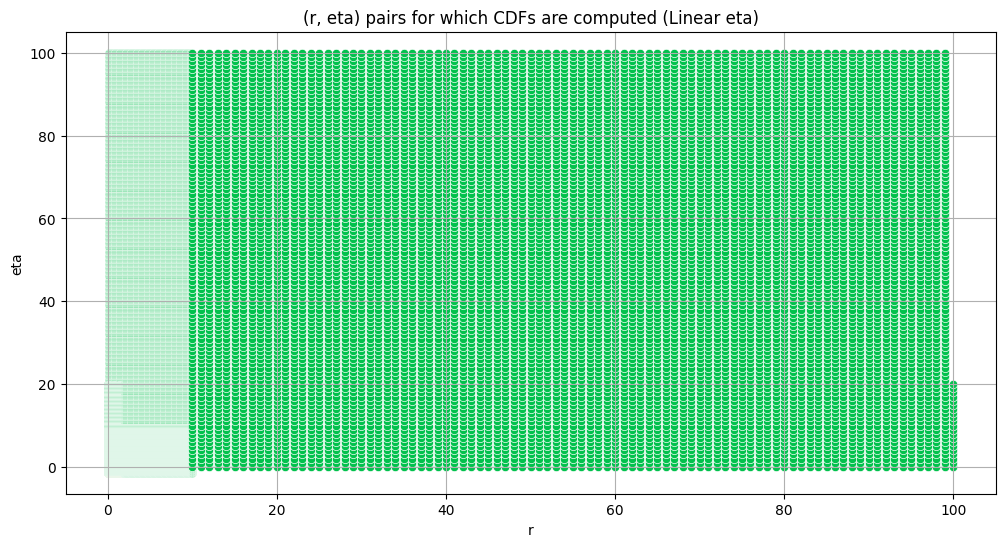

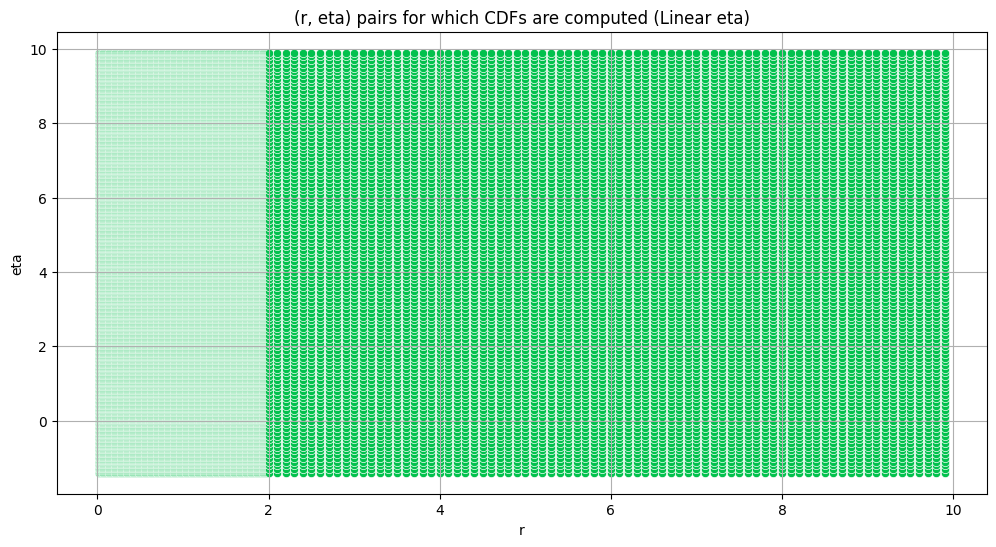

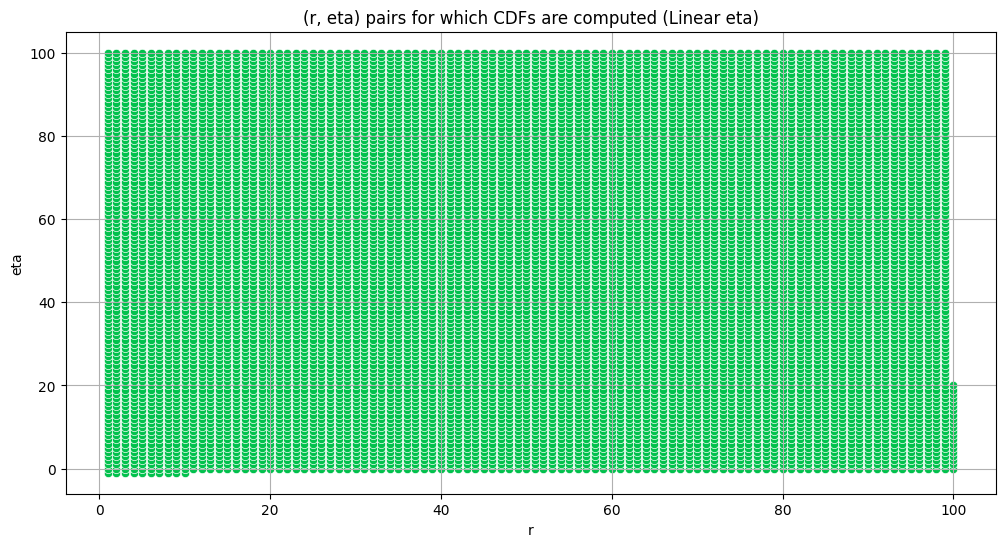

/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,r,eta,variance,kurtosis
count,51883.000000,51883.000000,5.188300e+04,5.064200e+04
mean,11.990701,21.476312,inf,inf
std,22.639851,28.237512,inf,NaN
min,0.020000,-1.400000,0.000000e+00,4.787254e-04
25%,1.000000,3.000000,9.882555e-01,1.513901e-02
50%,1.970000,7.600000,1.482803e+00,1.950077e-01
75%,8.100000,32.000000,5.742021e+00,6.565170e-01
max,100.000000,100.000000,1.797693e+308,inf


In [7]:
create_scatter_plot(all_cdfs_df)
create_scatter_plot(all_cdfs_df[(all_cdfs_df['r'] < 10) & (all_cdfs_df['eta'] < 10)])
create_scatter_plot(coarse_cdf_df)

all_cdfs_df.describe()

In [8]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [9]:
''' Only need to run commented code once'''    
for group in  GROUPS:
    print(f'{GROUP.capitalize()} {group}')
    obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                             n_bootstrap=n_bootstrap, 
                                                                             bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                             metric= np.var, 
                                                                             ci=ci)
    obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                 n_bootstrap=n_bootstrap, 
                                                                                 bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                 metric= stats.kurtosis, ci=ci)  
    master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
    master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
    master_df.loc[group, 'total_samples'] = group_total_samples[group]

master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'), index_col=GROUP)
var_kurt_df = pd.read_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'), index_col=GROUP)
master_df

Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0


In [10]:
def add_tests_to_df(cdfs_df, group, var_kurt_df, ksstats):
    cdfs_df['pass_var'] = (cdfs_df['variance'] > var_kurt_df.loc[group, 'var_lower']) & (cdfs_df['variance'] < var_kurt_df.loc[group, 'var_upper'])
    cdfs_df['pass_kurt'] = (cdfs_df['kurtosis'] > var_kurt_df.loc[group, 'kurt_lower']) & (cdfs_df['kurtosis'] < var_kurt_df.loc[group,'kurt_upper'])
    cdfs_df['ksstat'] = ksstats
    cutoff = stats.kstwo(n=var_kurt_df.loc[group, 'total_samples']).isf(0.05)
    cdfs_df['pass_kstest'] = cdfs_df['ksstat'].apply(lambda x: True if x < cutoff else False)
    return cdfs_df

####
Layer  2


100%|██████████| 51883/51883 [00:10<00:00, 4807.02it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 3180, Without approximation : 3180.0


/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


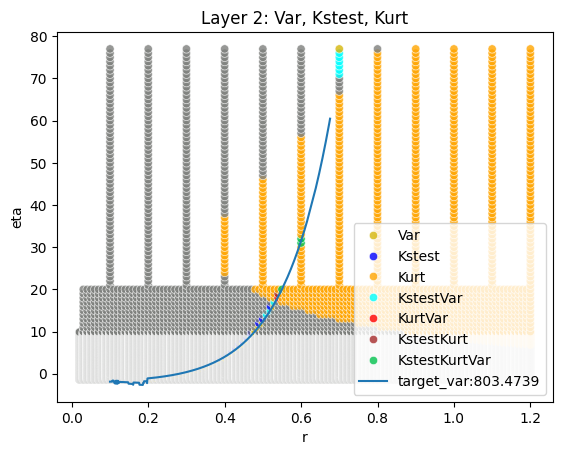

####
Layer  3


100%|██████████| 51883/51883 [00:26<00:00, 1985.67it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 12720, Without approximation : 12720.0


/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


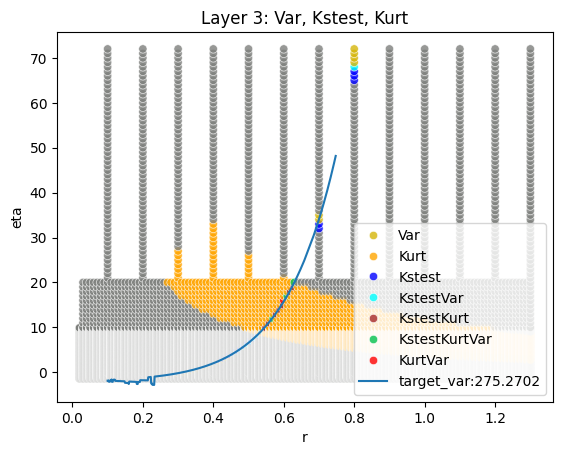

####
Layer  4


100%|██████████| 51883/51883 [01:36<00:00, 539.97it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 50880, Without approximation : 50880.0


/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


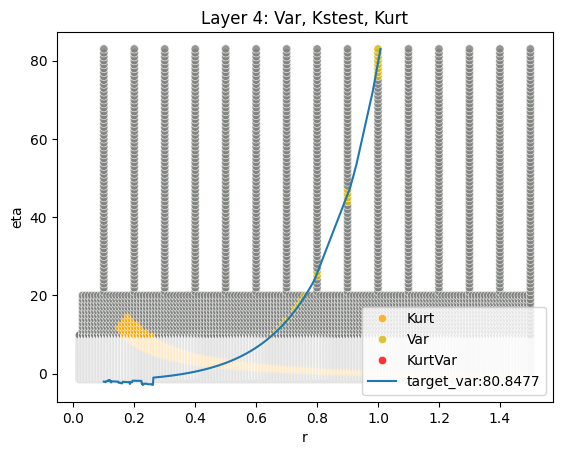

####
Layer  5


100%|██████████| 51883/51883 [03:00<00:00, 287.82it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 203520.0


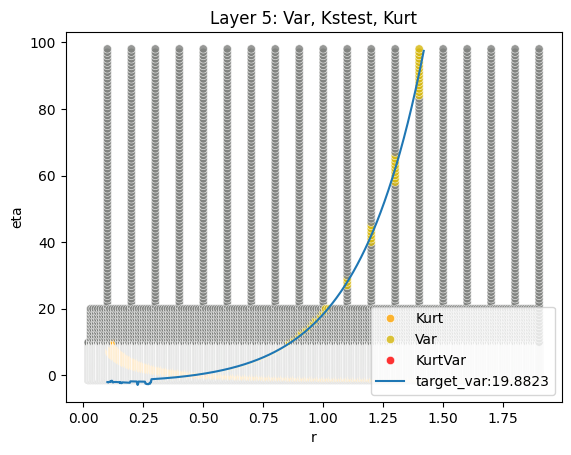

####
Layer  6


100%|██████████| 51883/51883 [03:01<00:00, 286.26it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 814080.0


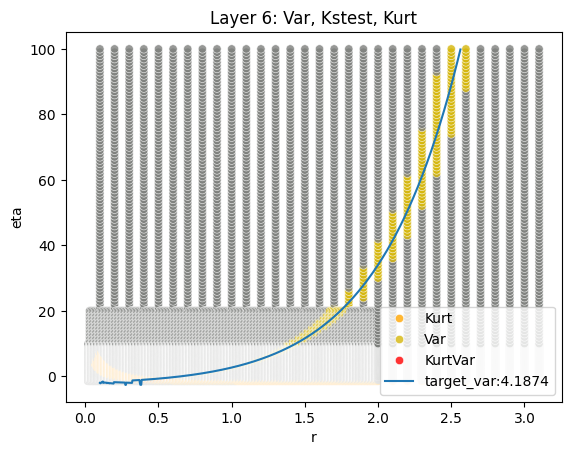

####
Layer  7


100%|██████████| 51883/51883 [03:00<00:00, 287.71it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 3256320.0


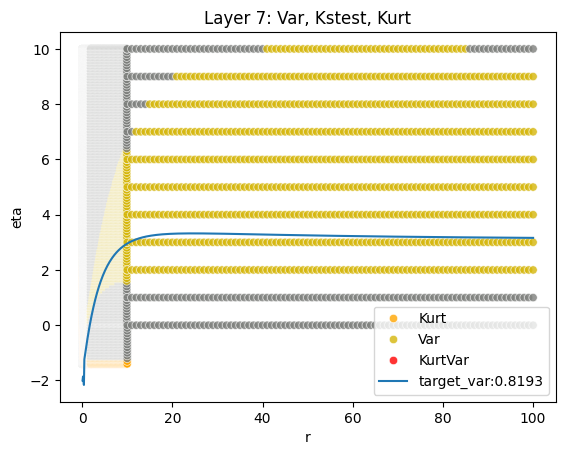

####
Layer  8


100%|██████████| 51883/51883 [02:59<00:00, 289.75it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 13025280.0


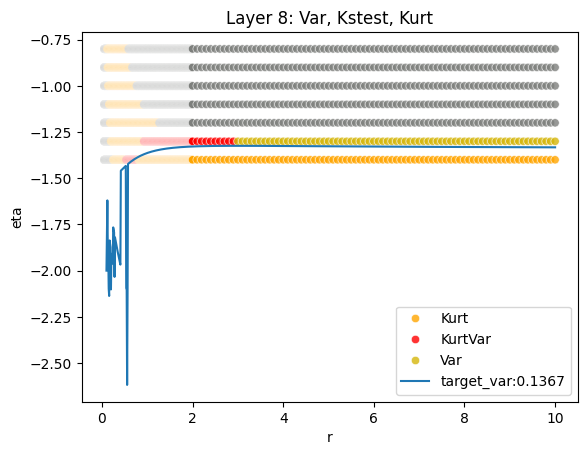

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0,0.42,5.7,0.018069,0.024030
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0,0.51,7.3,0.004615,0.012029
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0,0.44,1.4,0.006270,0.006018
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0,0.47,0.2,0.005236,0.003010
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0,0.51,-0.6,0.004349,0.001505
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0,0.97,-0.9,0.010413,0.000753
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0,1.44,-1.2,0.051520,0.000376


In [11]:
''' Only need to run commented code once'''
sorted_params = sorted(all_cdfs)
group_cdf_df_dict = dict()

for i, group in enumerate(GROUPS):
    print(f"####\n{GROUP.capitalize()} ", group)
    sample = group_data_map[group]
    group_cdf_df = all_cdfs_df.copy()
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
    master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
    print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
    master_df.loc[group, 'kstest_stat_initial'] = min_stat
    cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

    group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
    
    group_cdf_df_dict[group] = group_cdf_df
    cols = ['pass_var', 'pass_kstest', 'pass_kurt']

    fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                          plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                          target_var = master_df.loc[group, 'obs_var'])
    fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

    # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
    # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

    # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    # plt.close(fig_var)
    # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    # plt.close(fig_kurt)

master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
pd.to_pickle(group_cdf_df_dict, os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))

group_cdf_df_dict = pd.read_pickle(os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"), index_col=GROUP)
master_df

In [12]:
''' Only need to run commented code once'''
best_params_eta0 = []
for i, group in enumerate(GROUPS):
    if master_df.loc[group, 'initial_eta'] != 0:
        sample = group_data_map[group]
        group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
        cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
        ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True)
        best_params_eta0.append(best_param_eta0[0])
        master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
    else:
        master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
        best_params_eta0.append(master_df.loc[group, 'initial_r'])
master_df['best_r_eta0'] = best_params_eta0
master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"), index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 1670.16it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 1894.25it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 568.35it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 282.49it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 286.34it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 293.74it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 295.59it/s]

Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0
layer,,,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0,0.42,5.7,0.018069,0.024030,0.060346,0.26
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0,0.51,7.3,0.004615,0.012029,0.037012,0.29
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0,0.44,1.4,0.006270,0.006018,0.023319,0.34
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0,0.47,0.2,0.005236,0.003010,0.005653,0.44
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0,0.51,-0.6,0.004349,0.001505,0.020507,0.74
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0,0.97,-0.9,0.010413,0.000753,0.082284,6.10
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0,1.44,-1.2,0.051520,0.000376,0.227351,6.00


In [13]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, use_matlab=True, eng=None, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)

    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + cnt}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + cnt}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}-{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Layer 2


100%|██████████| 1044/1044 [00:00<00:00, 7591.18it/s]


Finding Minimum after computing 1044 CDFs
Iter 1 layer 2 best parameters: ((0.4209, 5.738), 0.01745594298196202)


100%|██████████| 1044/1044 [00:00<00:00, 5658.91it/s]


Finding Minimum after computing 1044 CDFs
Iter 2 layer 2 best parameters: ((0.4209, 5.738), 0.01745594298196202)


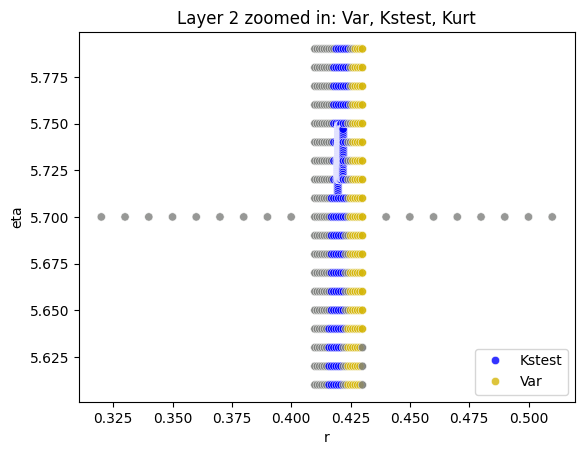

Layer 3


100%|██████████| 1254/1254 [00:00<00:00, 2064.57it/s]


Finding Minimum after computing 1254 CDFs
Iter 1 layer 3 best parameters: ((0.492, 6.18), 0.003877742883484636)
(0.4912, 6.177), 1300 of 1720
(0.4914, 6.187), 1350 of 1770
(0.4917, 6.177), 1400 of 1820
(0.4919, 6.187), 1450 of 1870
(0.4922, 6.179), 1500 of 1920
(0.4924, 6.189), 1550 of 1970
(0.4927, 6.179), 1600 of 2020
(0.4929, 6.189), 1650 of 2070


100%|██████████| 1668/1668 [00:00<00:00, 2139.73it/s]


Finding Minimum after computing 1668 CDFs
Iter 2 layer 3 best parameters: ((0.4921, 6.186), 0.003872991416462579)


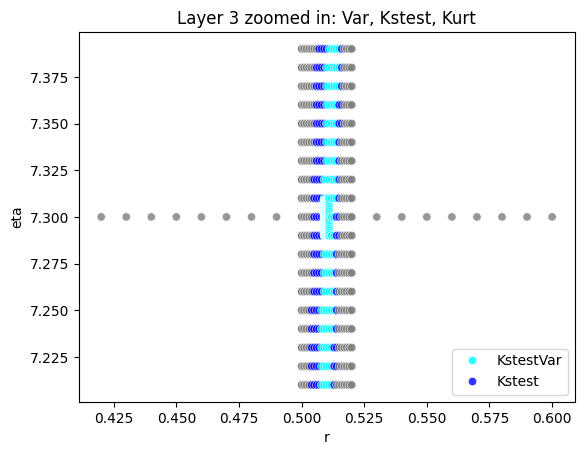

Layer 4


100%|██████████| 1399/1399 [00:02<00:00, 542.87it/s]


Finding Minimum after computing 1399 CDFs
Iter 1 layer 4 best parameters: ((0.4353, 1.298), 0.005274590798061252)
(0.4343, 1.288), 1400 of 1841
(0.4358, 1.289), 1450 of 1891


100%|██████████| 1460/1460 [00:02<00:00, 557.22it/s]


Finding Minimum after computing 1460 CDFs
Iter 2 layer 4 best parameters: ((0.4353, 1.298), 0.005274590798061252)


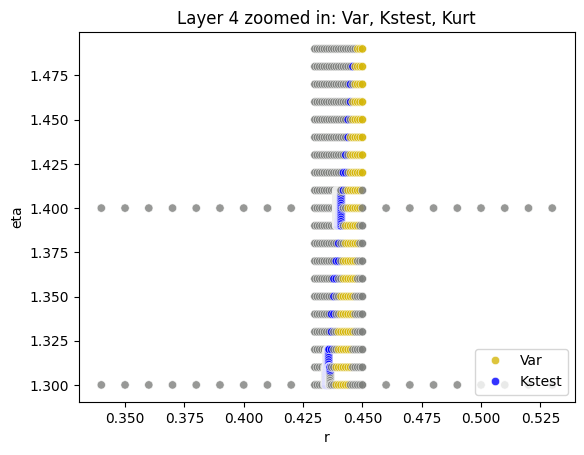

Layer 5


100%|██████████| 1367/1367 [00:04<00:00, 289.24it/s]


Finding Minimum after computing 1367 CDFs
Iter 1 layer 5 best parameters: ((0.461, 0.12293), 0.003813346359012426)
(0.4601, 0.12493), 1400 of 1820
(0.4604, 0.11493), 1450 of 1870
(0.4606, 0.12493), 1500 of 1920
(0.4609, 0.11493), 1550 of 1970
(0.4611, 0.12593), 1600 of 2020
(0.4614, 0.11593), 1650 of 2070
(0.4616, 0.12593), 1700 of 2120
(0.4619, 0.11593), 1750 of 2170


100%|██████████| 1786/1786 [00:06<00:00, 285.74it/s]


Finding Minimum after computing 1786 CDFs
Iter 2 layer 5 best parameters: ((0.46, 0.11593), 0.003748395439671648)
(0.45999, 0.11596), 1800 of 2241
(0.45999, 0.11583), 1850 of 2291
(0.45999, 0.11591), 1900 of 2341
(0.46, 0.11601), 1950 of 2391
(0.46, 0.1159), 2000 of 2441
(0.46, 0.11601), 2050 of 2491
(0.46, 0.1159), 2100 of 2541
(0.46001, 0.11599), 2150 of 2591
(0.46001, 0.11586), 2200 of 2641


100%|██████████| 1848/1848 [00:06<00:00, 290.93it/s]


Finding Minimum after computing 1848 CDFs
Iter 3 layer 5 best parameters: ((0.46001, 0.11583), 0.0037420454191549046)


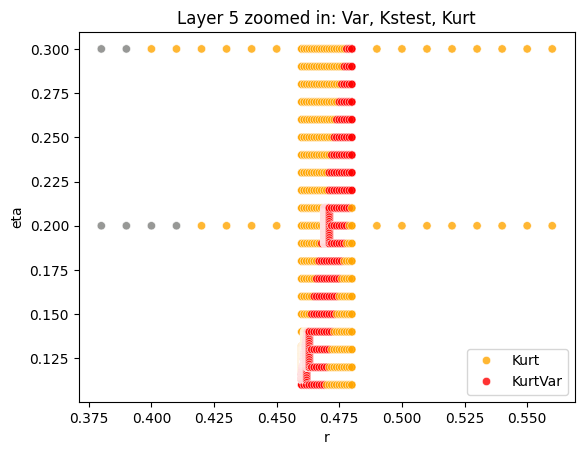

Layer 6


100%|██████████| 1686/1686 [00:05<00:00, 288.77it/s]


Finding Minimum after computing 1686 CDFs
Iter 1 layer 6 best parameters: ((0.52, -0.58), 0.003109999999999058)


100%|██████████| 1686/1686 [00:05<00:00, 289.80it/s]


Finding Minimum after computing 1686 CDFs
Iter 2 layer 6 best parameters: ((0.52, -0.58), 0.003109999999999058)


100%|██████████| 1686/1686 [00:05<00:00, 286.90it/s]


Finding Minimum after computing 1686 CDFs
Iter 3 layer 6 best parameters: ((0.52, -0.58), 0.003109999999999058)


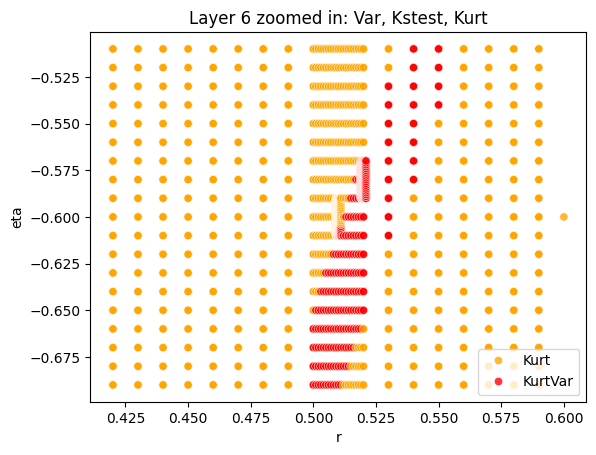

Layer 7


100%|██████████| 1709/1709 [00:05<00:00, 289.05it/s]


Finding Minimum after computing 1709 CDFs
Iter 1 layer 7 best parameters: ((0.91, -0.92), 0.008432433497601588)


100%|██████████| 1709/1709 [00:05<00:00, 290.31it/s]


Finding Minimum after computing 1709 CDFs
Iter 2 layer 7 best parameters: ((0.91, -0.92), 0.008432433497601588)


100%|██████████| 1709/1709 [00:05<00:00, 286.02it/s]


Finding Minimum after computing 1709 CDFs
Iter 3 layer 7 best parameters: ((0.91, -0.92), 0.008432433497601588)


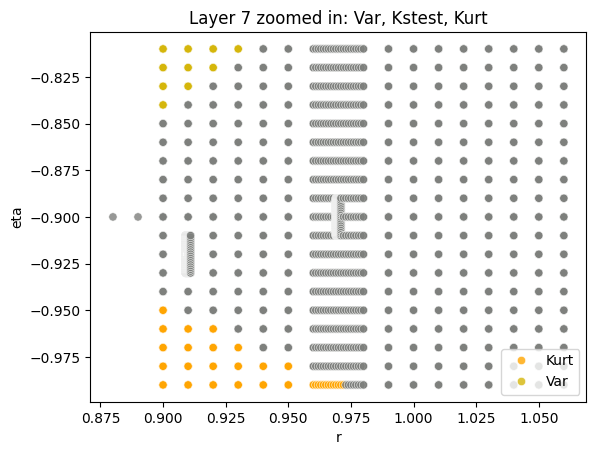

Layer 8


100%|██████████| 1716/1716 [00:06<00:00, 282.98it/s]


Finding Minimum after computing 1716 CDFs
Iter 1 layer 8 best parameters: ((0.7, -1.26), 0.03554324514215251)


100%|██████████| 1716/1716 [00:05<00:00, 294.93it/s]


Finding Minimum after computing 1716 CDFs
Iter 2 layer 8 best parameters: ((0.7, -1.26), 0.03554324514215251)
(0.7, -1.2601), 1750 of 2150
(0.7, -1.2601), 1800 of 2200
(0.70001, -1.26), 1850 of 2250
(0.70001, -1.2601), 1900 of 2300


100%|██████████| 1721/1721 [00:05<00:00, 287.75it/s]


Finding Minimum after computing 1721 CDFs
Iter 3 layer 8 best parameters: ((0.7, -1.26), 0.03554324514215251)


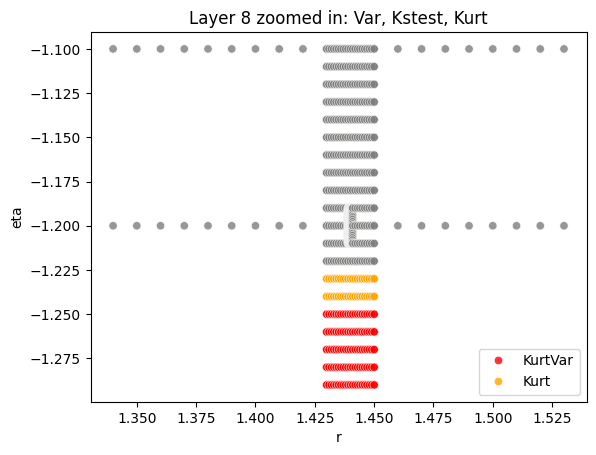

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,iter1_r,iter1_eta,kstest_stat_iter1,iter2_r,iter2_eta,kstest_stat_iter2,iter3_r,iter3_eta,kstest_stat_iter3,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0,0.42,5.7,0.018069,...,0.4209,5.73800,0.017456,0.4209,5.73800,0.017456,NaN,NaN,NaN,6034
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0,0.51,7.3,0.004615,...,0.4920,6.18000,0.003878,0.4921,6.18600,0.003873,NaN,NaN,NaN,122248
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0,0.44,1.4,0.006270,...,0.4353,1.29800,0.005275,0.4353,1.29800,0.005275,NaN,NaN,NaN,64395
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0,0.47,0.2,0.005236,...,0.4610,0.12293,0.003813,0.4600,0.11593,0.003748,0.46001,0.11583,0.003742,128790
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0,0.51,-0.6,0.004349,...,0.5200,-0.58000,0.003110,0.5200,-0.58000,0.003110,0.52000,-0.58000,0.003110,193185
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0,0.97,-0.9,0.010413,...,0.9100,-0.92000,0.008432,0.9100,-0.92000,0.008432,0.91000,-0.92000,0.008432,25440
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0,1.44,-1.2,0.051520,...,0.7000,-1.26000,0.035543,0.7000,-1.26000,0.035543,0.70000,-1.26000,0.035543,1507


In [14]:
SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [2, 2, 2, 3, 3, 3, 3, 3]))

if SKIP_OPTIMIZE_STEP:
    master_df['kstest_stat'] = master_df['kstest_stat_initial']
    master_df[f'best_r'] = master_df['initial_r']
    master_df[f'best_eta'] = master_df['initial_eta']
else:
    for group in GROUPS: 
        print(f"{GROUP.capitalize()} {group}")
        sample = group_data_map[group]
        initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
        r_granularity = 10
        eta_granularity = 10
        for i in range(-1, -5, -1):
            if tuple([round_to_sigfigs(initial_r + 10.**i), initial_eta]) in all_cdfs:
                r_granularity = 10.**i
            if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i)]) in all_cdfs:
                
                eta_granularity = 10.**i

        for d in range(1, NUM_ITERS[group] + 1):
            if d == 1:
                initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            else:
                initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
            r_granularity = r_granularity * 10.0**(-d+1) 
            eta_granularity = eta_granularity * 10.0**(-d+1) 

            r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
            eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
            simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "CDFs"), folder_name=f'{GROUP}{group}', n_samples = 200, debug=False)
            cdfs_dict = combine_pickles(os.path.join(CWD, "CDFs", f'{GROUP}{group}'))
            ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True)

            temp_df = create_kurt_var_ksstat_df(cdfs_dict)
            temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
            group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
            master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
            master_df.loc[group, 'kstest_stat_best'] = kstest_stat
            master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
            master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
            
            print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

        temp_df = group_cdf_df_dict[group]
        eps = 0.1
        filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                        (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                        (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                        (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']
        fig = combo_test_plot(filtered_df, cols, plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}")
        fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
        
master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', f'best_r', f'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'), index_col = GROUP)
master_df

In [15]:
NUM_ITERS

{2: 2, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 3}

## Comparing Empirical and Computed CDF/PDF

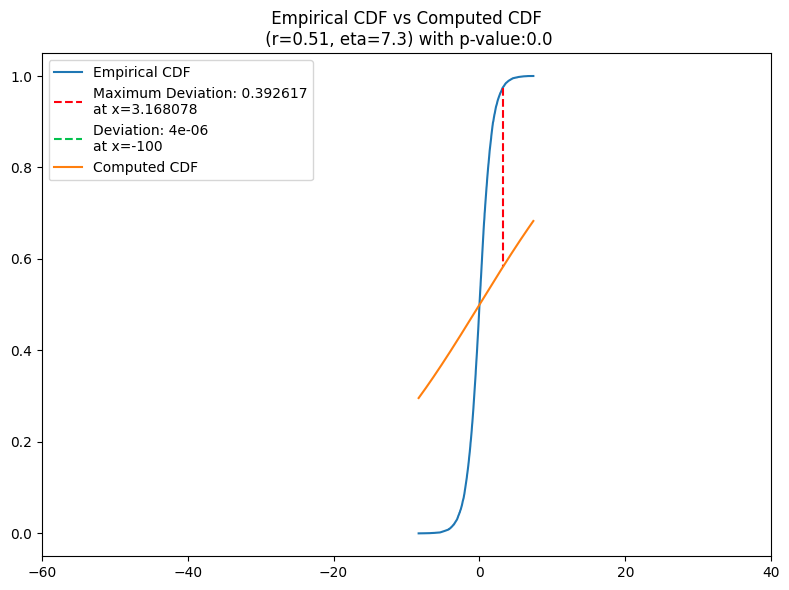

In [16]:
# Example Cell
group = 3
visualize_cdf(sample = sample_prior(1, 1, 10000), 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

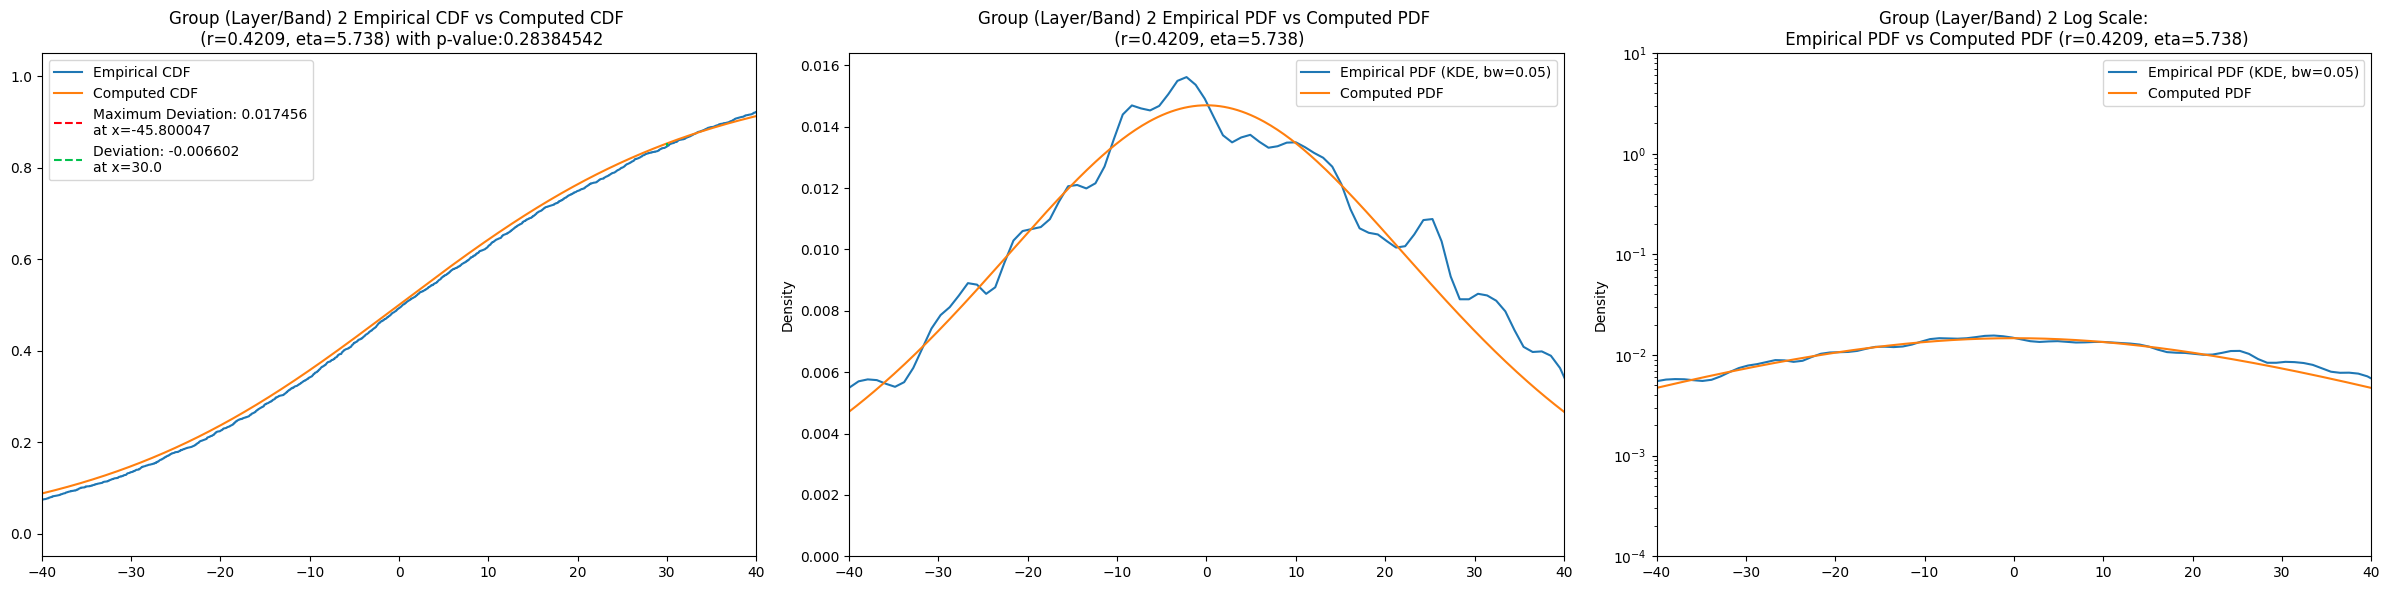

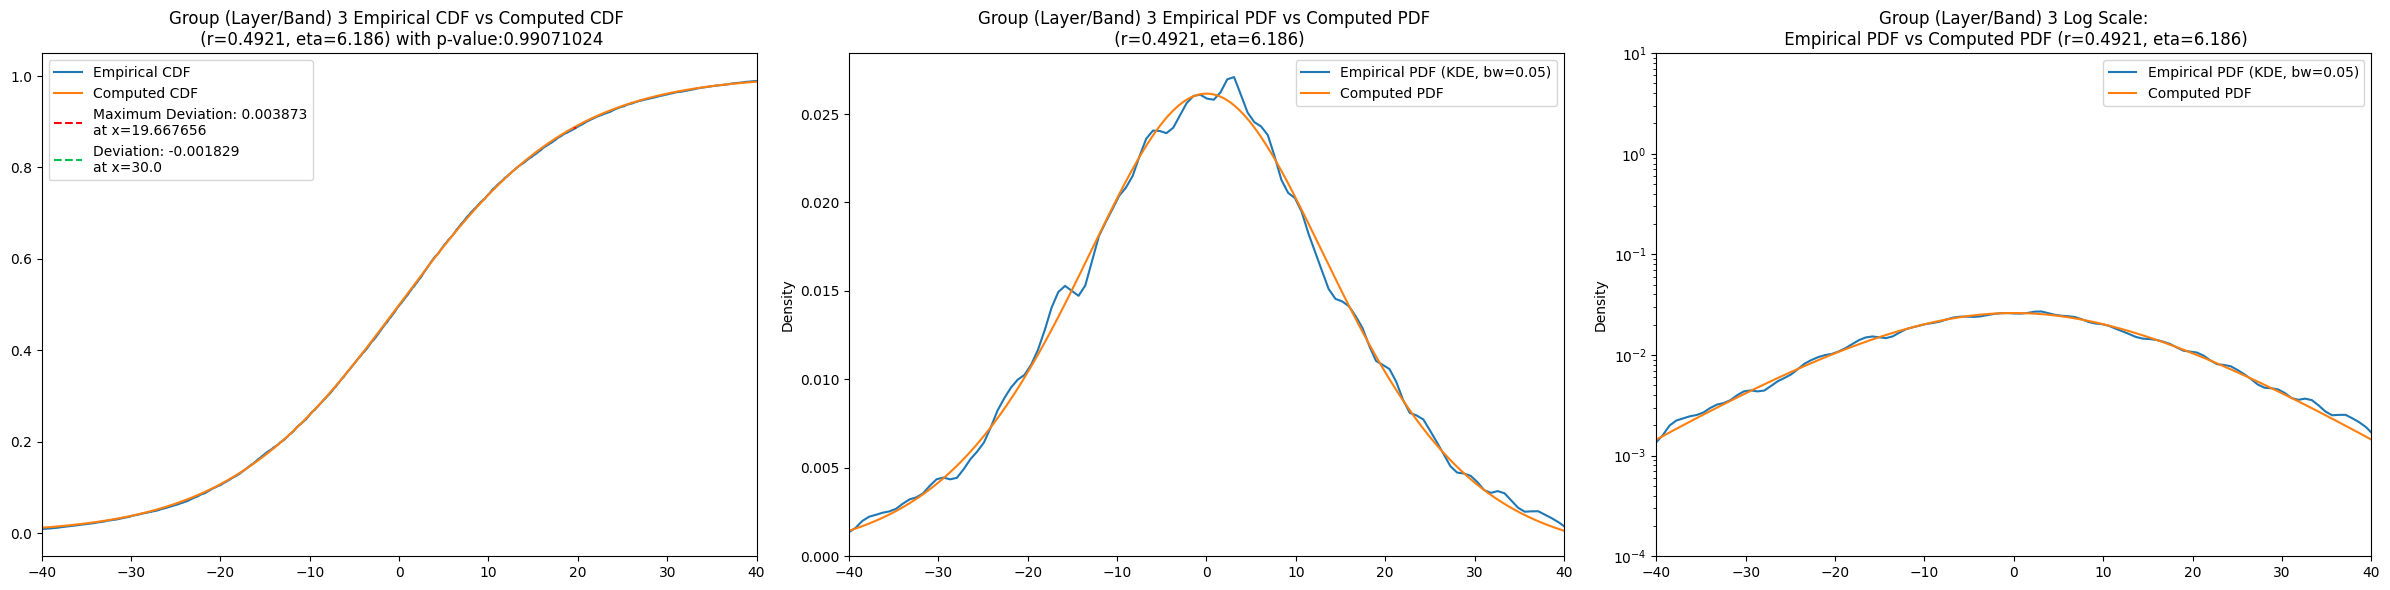

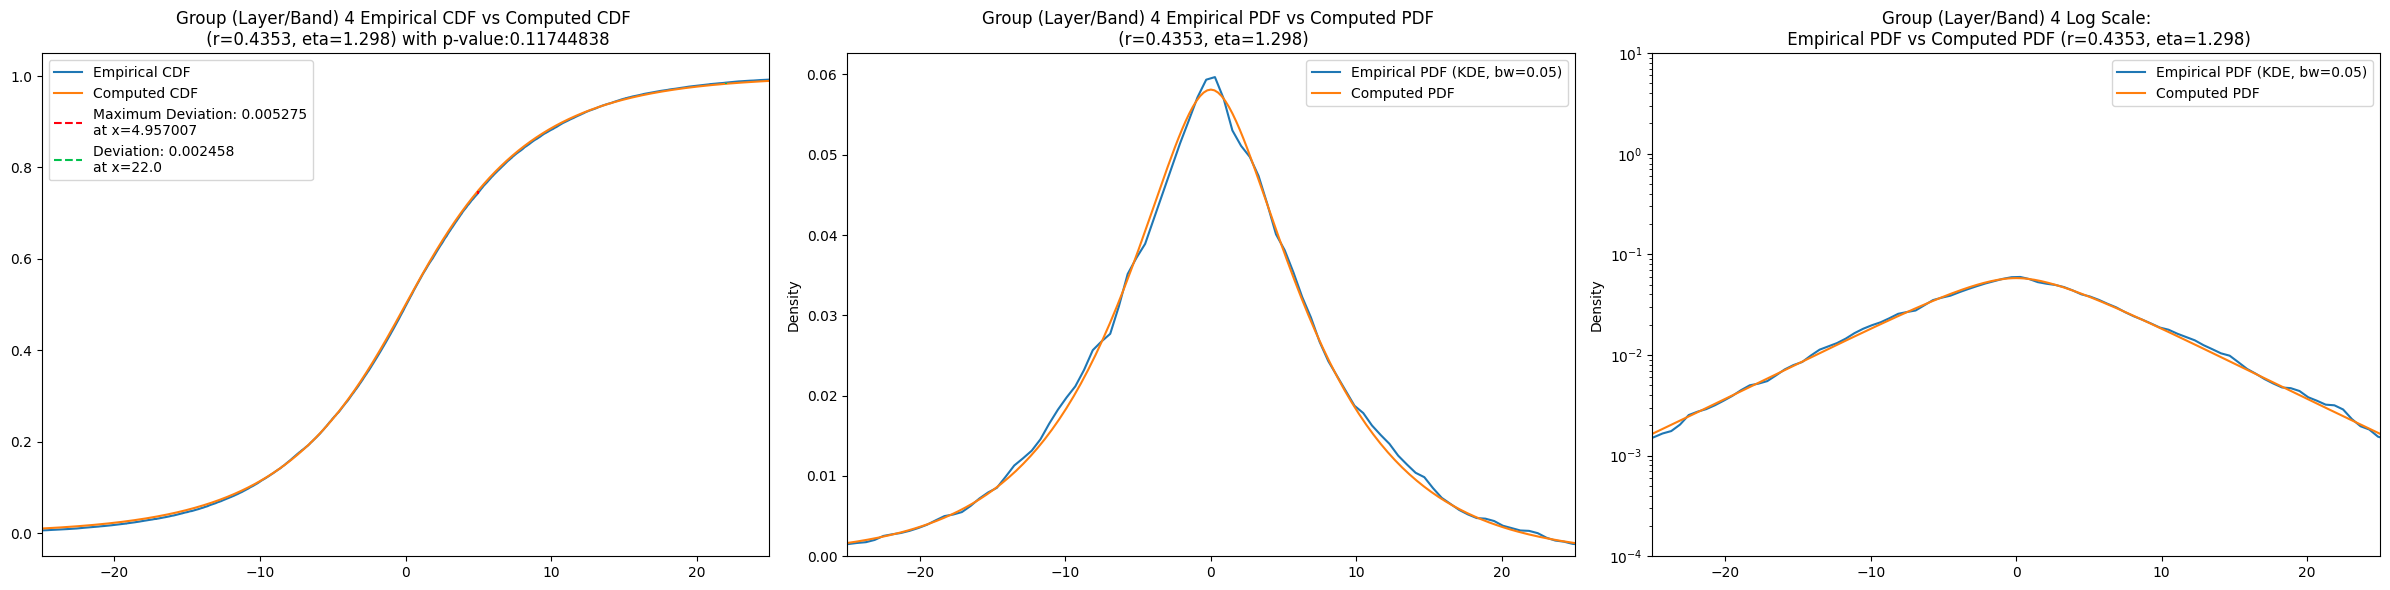

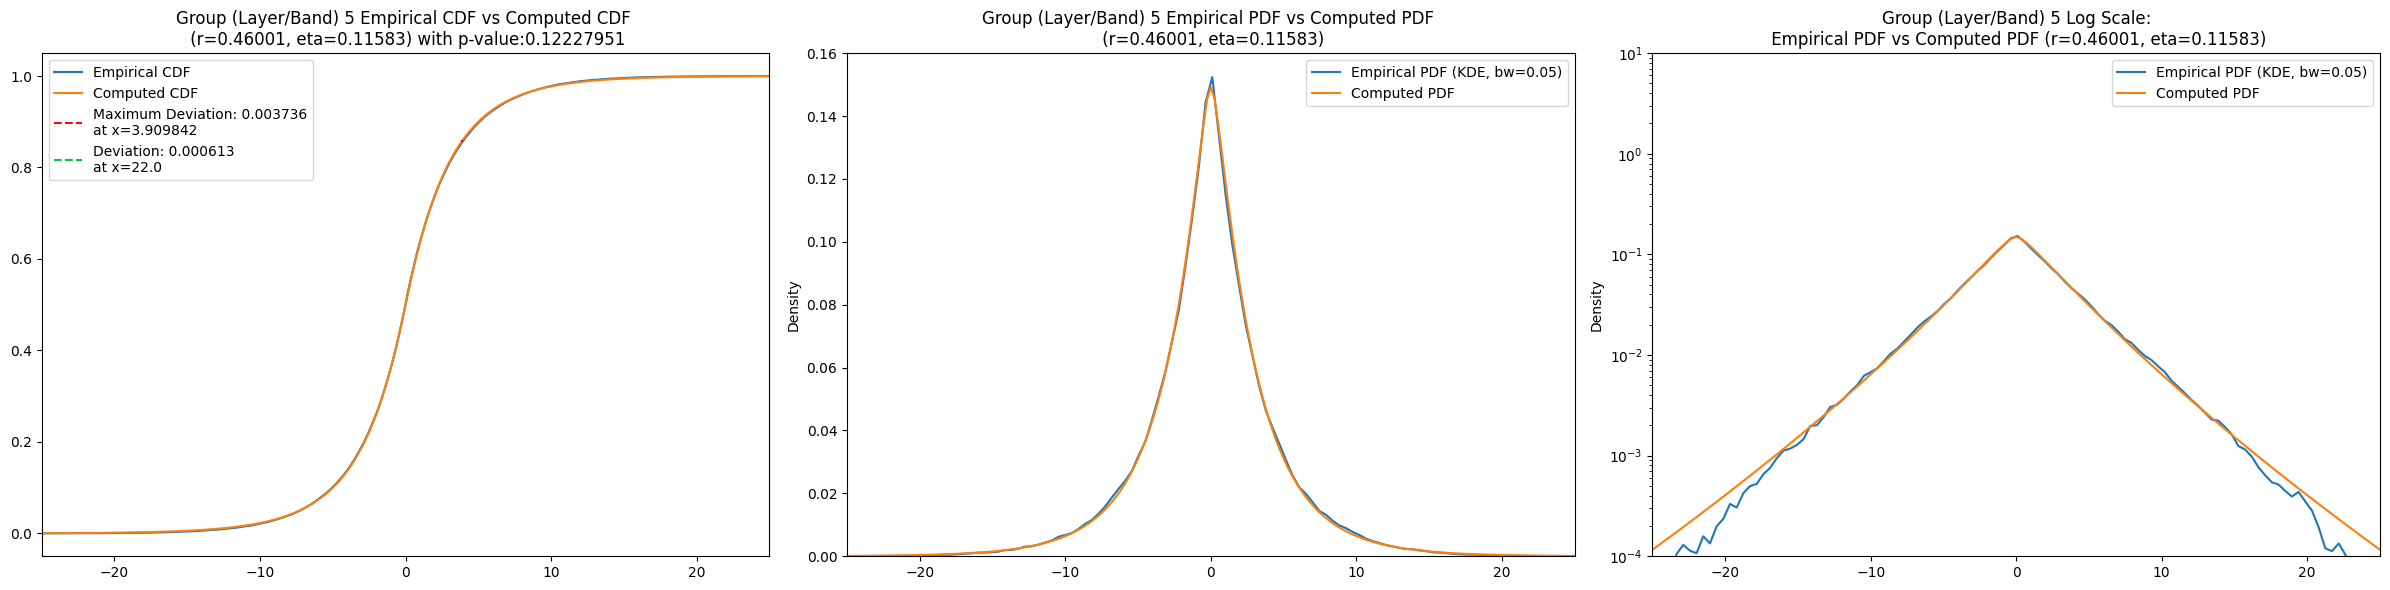

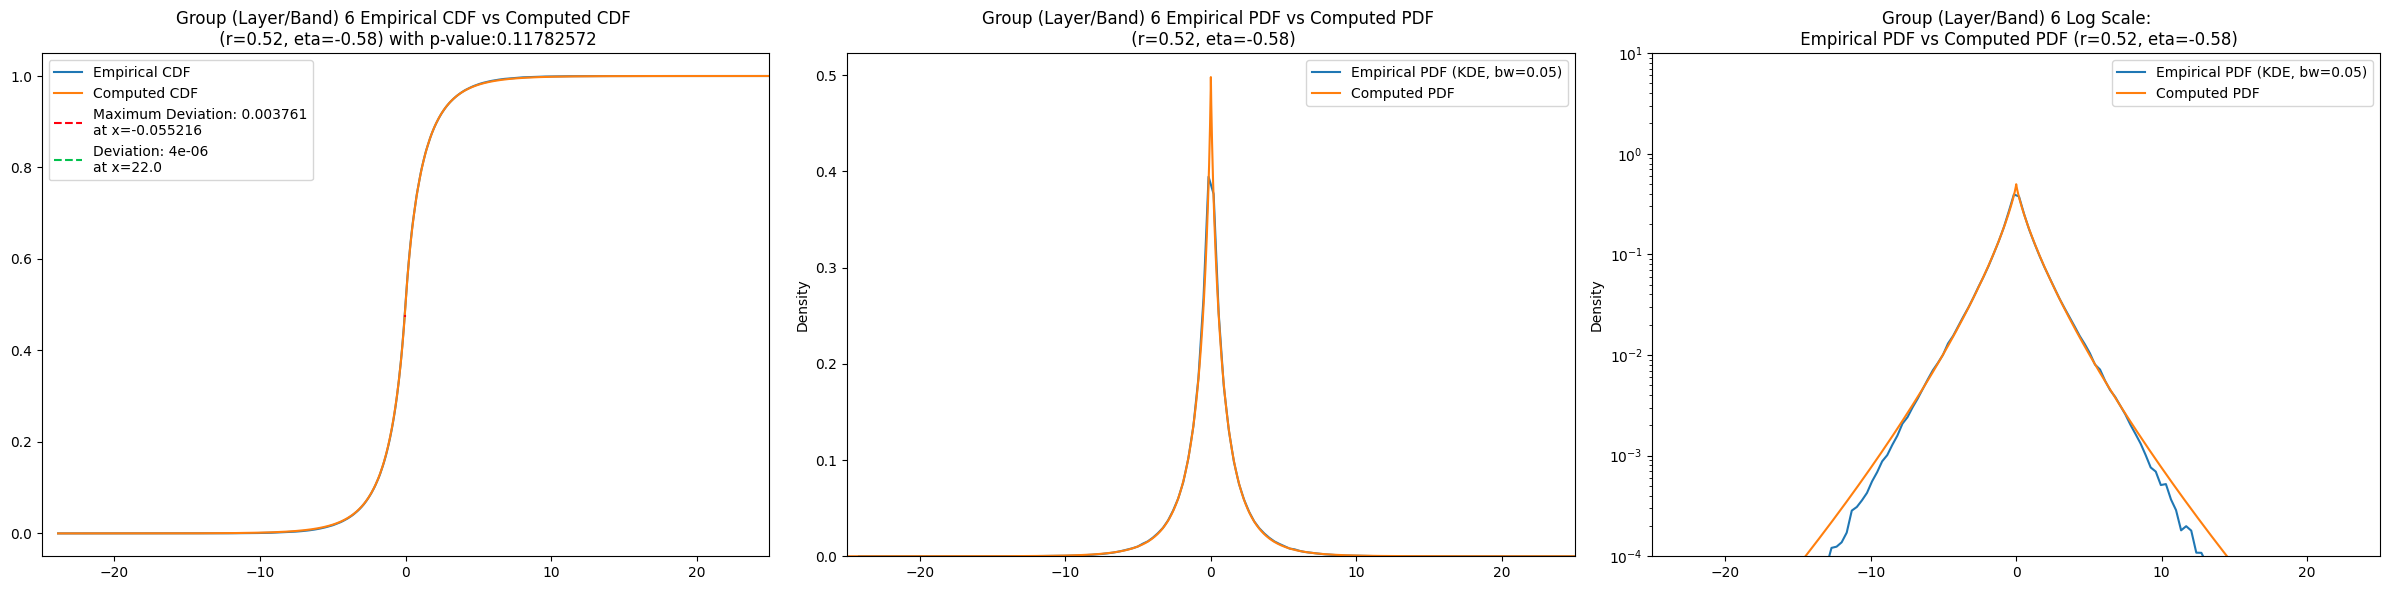

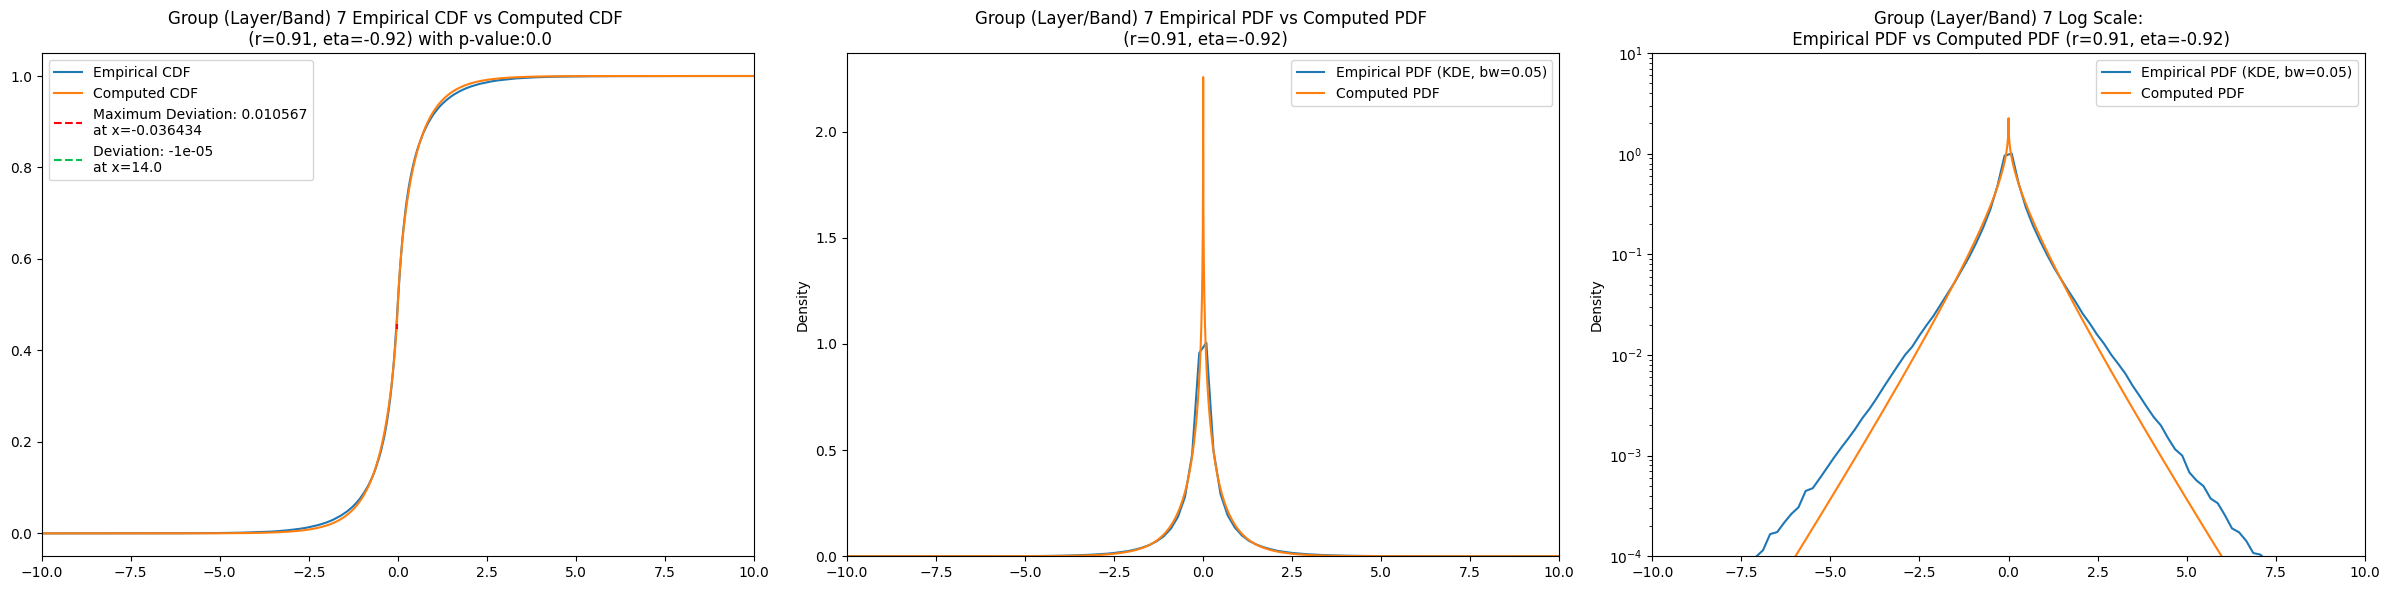

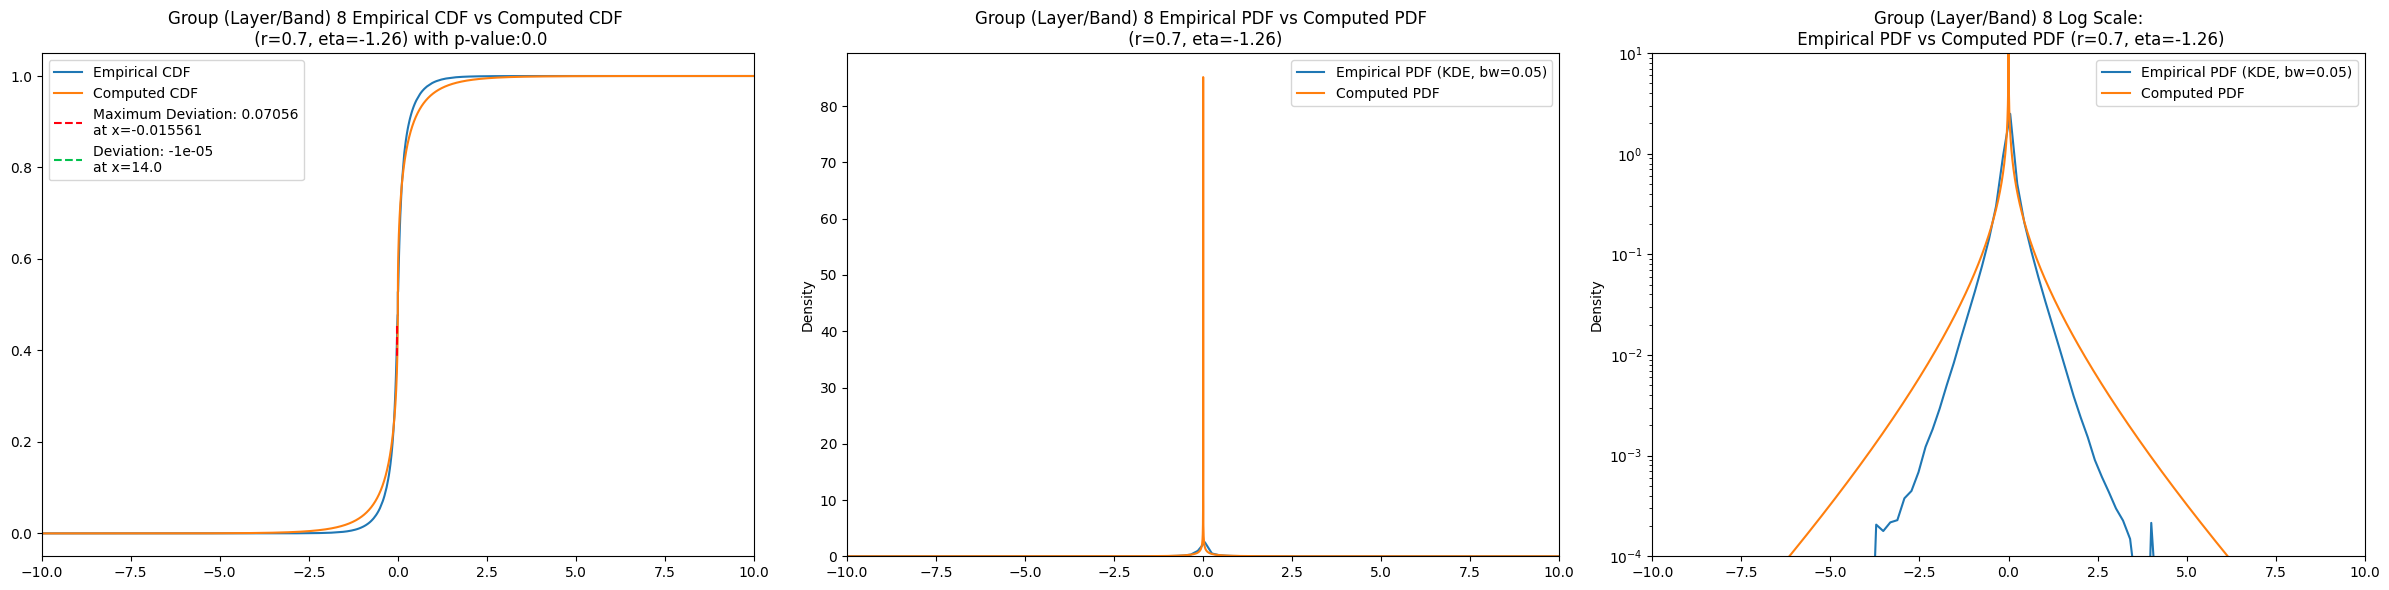

In [17]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-(40 - group//3.1*15), (40 - group//3.1*15)),
                    provided_loc=(30 - group//3.1*8))
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace

In [18]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [19]:
for group in GROUPS:
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, 50))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, 50))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_compare_priors.csv'))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df_compare_priors.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0,0.42,5.7,0.018069,...,27.782300,0.019503,1.755550e-01,25.439100,0.036392,4.282210e-04,20.752800,0.036305,4.458110e-04,2.838500e-01
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0,0.51,7.3,0.004615,...,16.031400,0.010128,1.460870e-01,14.012900,0.022665,4.151010e-06,11.277100,0.026410,3.854630e-08,9.907100e-01
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0,0.44,1.4,0.006270,...,8.001070,0.020474,5.852830e-19,7.104980,0.014498,1.017140e-09,5.719650,0.018489,1.538450e-15,1.174600e-01
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0,0.47,0.2,0.005236,...,3.590200,0.030178,1.856120e-161,3.138870,0.002344,2.129390e-01,2.574090,0.010570,3.529230e-20,6.676900e-03
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0,0.51,-0.6,0.004349,...,1.426190,0.042375,0.000000e+00,1.246800,0.014481,1.041130e-148,1.010540,0.017941,4.909420e-228,2.890500e-07
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0,0.97,-0.9,0.010413,...,0.539656,0.052929,0.000000e+00,0.472760,0.025282,0.000000e+00,0.378321,0.026440,0.000000e+00,1.521600e-201
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0,1.44,-1.2,0.051520,...,0.196027,0.056358,0.000000e+00,0.172569,0.029152,0.000000e+00,0.137349,0.028140,0.000000e+00,0.000000e+00


# Examining Tail Behavior

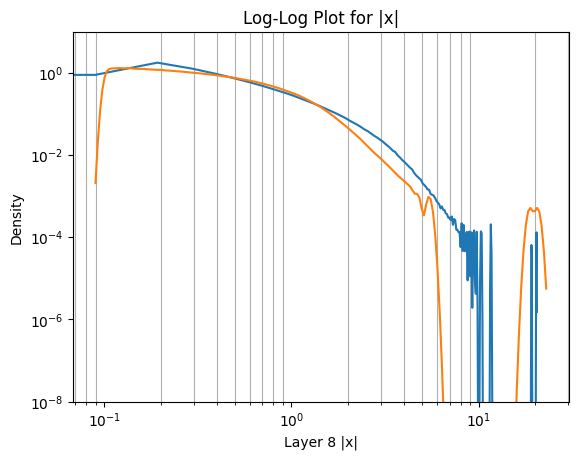

In [20]:
bw = 0.05
group = 7
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(os.path.join(CWD, "plots", 'log-log_plot_layer_7.jpg'), bbox_inches = 'tight')

bw = 0.05
group = 8
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(os.path.join(CWD, "plots", 'log-log_plot_layer_8.jpg'), bbox_inches = 'tight')

In [21]:
def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
    if metric_name == 'kstest_ratio':
        metric = compute_ksratio
    elif metric_name == 'kstest_stat':
        metric = compute_ksstat_tail

    for tail_cutoff in tail_cutoffs:
        metrics = []
        for layer in layers:
            if distro == 'gengamma':
                cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
            elif distro == 'gaussian':
                cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
            elif distro == 'laplace':
                cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
            elif distro == 't':
                cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
            metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
        master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
for group in GROUPS:
    add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
    add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:577: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:577: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:577: RuntimeWarning: divide by zero encountered in divide
  tail_ratios =

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,kstest_ratio_gengamma_tail0,kstest_ratio_gengamma_tail10,kstest_ratio_gaussian_tail0,kstest_ratio_gaussian_tail10,kstest_ratio_laplace_tail0,kstest_ratio_laplace_tail10,kstest_ratio_t_tail0,kstest_ratio_t_tail10,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,,,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0,0.42,5.7,0.018069,...,"(0.1239, 1.0126)","(0.1239, 1.0126)","(0.9368, 1.9545)","(0.9368, 1.9545)","(0.95089, 7.3557)","(0.95089, 7.3557)","(0.015521, 1.04)","(0.015521, 1.04)",0.018069,0.018069
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0,0.51,7.3,0.004615,...,"(0.25381, 1.016)","(0.25381, 1.016)","(0.96671, 76.943)","(0.96671, 76.943)","(0.96151, 2839.9)","(0.96151, 2839.9)","(0.0074015, 1.1147)","(0.0074015, 1.1147)",0.004615,0.003824
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0,0.44,1.4,0.006270,...,"(0.098794, 1.0029)","(0.098794, 1.0029)","(0.93633, 391120.0)","(0.97872, 391120.0)","(0.95756, 119260000.0)","(0.95756, 119260000.0)","(0.003275, 1.0744)","(0.003275, 1.0176)",0.005812,0.005487
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0,0.47,0.2,0.005236,...,"(0.28817, 3.9814)","(0.28817, 3.9814)","(0.90723, 1.8721999999999998e+35)","(0.98075, 1.8721999999999998e+35)","(0.95007, 1.8763e+47)","(0.97884, 1.8763e+47)","(0.006972, 1.0662)","(0.006972, 1.0104)",0.003322,0.001374
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0,0.51,-0.6,0.004349,...,"(0.37732, 1.0407)","(0.37732, 1.0407)","(0.87959, 3.0205e+57)","(0.99905, 3.0205e+57)","(0.9364, 2.0407000000000003e+76)","(0.99905, 2.0407000000000003e+76)","(0.011194, 1.2183)","(0.011194, 1.0041)",0.002538,0.000984
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0,0.97,-0.9,0.010413,...,"(0.95921, 15312000.0)","(0.99998, 15312000.0)","(0.8501, 6.528000000000002e+269)","(0.99998, 6.528000000000002e+269)","(0.90641, inf)","(0.99998, inf)","(0.037871, 1.5063)","(0.037871, 1.0006)",0.008446,0.000030
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0,1.44,-1.2,0.051520,...,"(0.32023, 962020000000000.0)","(1.0, 962020000000000.0)","(0.83653, inf)","(1.0, inf)","(0.89532, inf)","(1.0, inf)","(0.061503, 1.7144)","(0.37126, 1.0)",0.002504,0.000010


# Results

## KS-Test Statistics

In [22]:
import pandas as pd
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

In [23]:
master_df.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,total_samples,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,kstest_stat_best,kstest_stat_iter1,kstest_stat_iter2,kstest_stat_iter3,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
0,3180.0,0.018069,0.024030,0.060346,0.017456,0.017456,0.017456,NaN,0.019503,0.036392,0.036305,0.018069,0.018069
1,12720.0,0.004615,0.012029,0.037012,0.003873,0.003878,0.003873,NaN,0.010128,0.022665,0.026410,0.004615,0.003824
2,50880.0,0.006270,0.006018,0.023319,0.005275,0.005275,0.005275,NaN,0.020474,0.014498,0.018489,0.005812,0.005487
3,203520.0,0.005236,0.003010,0.005653,0.003742,0.003813,0.003748,0.003742,0.030178,0.002344,0.010570,0.003322,0.001374
4,814080.0,0.004349,0.001505,0.020507,0.003110,0.003110,0.003110,0.003110,0.042375,0.014481,0.017941,0.002538,0.000984
5,3256320.0,0.010413,0.000753,0.082284,0.008432,0.008432,0.008432,0.008432,0.052929,0.025282,0.026440,0.008446,0.000030
6,13025280.0,0.051520,0.000376,0.227351,0.035543,0.035543,0.035543,0.035543,0.056358,0.029152,0.028140,0.002504,0.000010
